In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import datetime
import scipy.stats as stats
import statistics


In [2]:
#Lectura
data = pd.read_csv('results.csv', sep=';')
#Columnas
data.columns = ['Fecha','IP Origen','IP Destino','Servicio','Accion','doc_count']
#Serie a Str
data['IP Destino'] = data['IP Destino'].map(str)
data['IP Origen'] = data['IP Origen'].map(str)
#De Epochs a Fecha
data['Fecha'] = data['Fecha'].astype(str).str[:-3]
data['Fecha'] = pd.to_datetime(data['Fecha'], unit = 's')
# Transformamos la columna Servicio a Puerto
def limpiar_servicio(servicio):
    string=re.search('\(([^)]+)', servicio).group(1)
    return string
data['Servicio']=data['Servicio'].apply(limpiar_servicio)

df1=data

# Creamos IP TYPE con el fin de diferenciar nuestra clasificación

# ip priv
# https://es.wikipedia.org/wiki/Red_privada
df1['IP Destino']=df1['IP Destino'].map(str)

df1.loc[(df1['IP Destino'].str.startswith('10.', na = False) == True)|
        (df1['IP Destino'].str.startswith('169.254', na = False) == True)|
        (df1['IP Destino'].str.startswith(('172.16','172.17','172.18','172.19','172.20','172.21','172.22', '172.23','172.24','172.25','172.26','172.27','172.28','172.29','172.30','172.31'), na = False) == True)|
        (df1['IP Destino'].str.startswith('192.168', na = False) == True), 'ip_type_destino'] = 'Int'
df1['ip_type_destino'] = df1['ip_type_destino'].fillna('Ext')


# Creamos Port Lvl con el fin de identificar los puertos comunmente atacados:

df1['Servicio']=df1['Servicio'].map(str)

df1.loc[
    # FTP 
        (df1['Servicio'] =='20')|
        (df1['Servicio'] =='21')|
    # SSH
        (df1['Servicio'] == '22')|
    # Telnet
         (df1['Servicio'] == '23')|
    # SMTP -> Por e-mail, spam
        (df1['Servicio'] == '25')|
    # DNS -> Ataques DDoS
         (df1['Servicio'] == '53')|
         (df1['Servicio'] == '88')|
         (df1['Servicio'] == '445')|
    #
         (df1['Servicio'] == '110')|
    #
         (df1['Servicio'] == '135')|
    #
         (df1['Servicio'] == '137')|
    #
         (df1['Servicio'] == '138')|
    # NetBIOS -> Impresora
         (df1['Servicio'] == '139')|
    # SQL Server y MySQL  puertos por default -> distribución de Malware
         (df1['Servicio'] == '1433')|
    #
         (df1['Servicio'] == '1434')|
    #
         (df1['Servicio'] == '3306')|
    # Postgres SQL
         (df1['Servicio'] == '5432')|
    # Escritorio remoto
         (df1['Servicio'] == '3389'), 'Port Lvl'] = 'Peligroso'

df1['Port Lvl'] = df1['Port Lvl'].fillna('Seguro')

# Para identificar el estatus 
df1['Accion']=df1['Accion'].map(str)
df1.loc[
    # No pasó el firewall
        (df1['Accion'] == 'drop')|
        (df1['Accion'] == 'stop')|
        (df1['Accion'] == 'reject'),
    'Action'] = 'No Paso'

df1['Action'] = df1['Action'].fillna('Paso')
df1['aux_indx'] = df1.index
df1['IP Origen']=df1['IP Origen'].map(str)
df1.loc[(df1['IP Origen'].str.startswith('10.', na = False) == True)|
        (df1['IP Origen'].str.startswith('169.254', na = False) == True)|
        (df1['IP Origen'].str.startswith(('172.16','172.17','172.18','172.19','172.20','172.21','172.22', '172.23','172.24','172.25','172.26','172.27','172.28','172.29','172.30','172.31'), na = False) == True)|
        (df1['IP Origen'].str.startswith('192.168', na = False) == True), 'ip_type_origen'] = 'Int'
df1['ip_type_origen'] = df1['ip_type_origen'].fillna('Ext')
df1.loc[(df1['ip_type_origen']=='Int') & 
        (df1['ip_type_destino']=='Int'), 'ip_type_interaccion']='II' # Mayor influencia
df1.loc[(df1['ip_type_origen']=='Int') & (df1['ip_type_destino']=='Ext'), 'ip_type_interaccion']='IE'
df1.loc[(df1['ip_type_origen']=='Ext') & (df1['ip_type_destino']=='Int'), 'ip_type_interaccion']='EI'
df1.loc[(df1['ip_type_origen']=='Ext') & (df1['ip_type_destino']=='Ext'), 'ip_type_interaccion']='EE'

In [3]:
df1.head()

,Fecha,IP Origen,IP Destino,Servicio,Accion,doc_count,ip_type_destino,Port Lvl,Action,aux_indx,ip_type_origen,ip_type_interaccion
0,2021-09-16 02:00:00,10.20.1.10,2.18.236.194,443,accept,4,Ext,Seguro,Paso,0,Int,IE
1,2021-09-16 02:00:00,10.10.2.162,2.22.148.42,80,accept,2,Ext,Seguro,Paso,1,Int,IE
2,2021-09-16 02:00:00,10.13.134.107,2.22.148.42,80,accept,1,Ext,Seguro,Paso,2,Int,IE
3,2021-09-16 02:00:00,10.15.17.231,2.22.148.42,80,accept,2,Ext,Seguro,Paso,3,Int,IE
4,2021-09-16 02:00:00,10.20.1.39,2.22.148.42,80,drop,3,Ext,Seguro,No Paso,4,Int,IE


In [4]:
data_ii1 = df1[df1['ip_type_interaccion']=='II'].set_index('Fecha').between_time('07:00','19:00')
data_ii2 = df1[df1['ip_type_interaccion']=='II'].set_index('Fecha').between_time('20:00','06:00')
data_ie1 = df1[df1['ip_type_interaccion']=='IE'].set_index('Fecha').between_time('07:00','19:00')
data_ie2 = df1[df1['ip_type_interaccion']=='IE'].set_index('Fecha').between_time('20:00','06:00')
data_ei1 = df1[df1['ip_type_interaccion']=='EI'].set_index('Fecha').between_time('07:00','19:00')
data_ei2 = df1[df1['ip_type_interaccion']=='EI'].set_index('Fecha').between_time('20:00','06:00')
data_ee1 = df1[df1['ip_type_interaccion']=='EE'].set_index('Fecha').between_time('07:00','19:00')
data_ee2 = df1[df1['ip_type_interaccion']=='EE'].set_index('Fecha').between_time('20:00','06:00')

In [5]:
print(data_ii1.shape,data_ii2.shape,data_ie1.shape,data_ie2.shape,data_ei1.shape,data_ei2.shape,data_ee1.shape,data_ee2.shape)

(539658, 11) (238798, 11) (1175790, 11) (455213, 11) (38031, 11) (23653, 11) (2712322, 11) (1901420, 11)


In [6]:
data_ei1.head()

,IP Origen,IP Destino,Servicio,Accion,doc_count,ip_type_destino,Port Lvl,Action,aux_indx,ip_type_origen,ip_type_interaccion
Fecha,,,,,,,,,,,
2021-09-16 07:00:00,172.32.2.20,10.2.0.236,7680,accept,1,Int,Seguro,Paso,114147,Ext,EI
2021-09-16 07:00:00,172.32.2.23,10.2.0.236,7680,accept,1,Int,Seguro,Paso,114148,Ext,EI
2021-09-16 07:00:00,172.32.2.24,10.2.0.236,7680,accept,2,Int,Seguro,Paso,114149,Ext,EI
2021-09-16 07:00:00,172.32.2.26,10.2.0.236,7680,accept,4,Int,Seguro,Paso,114150,Ext,EI
2021-09-16 07:00:00,172.32.2.29,10.2.0.236,7680,accept,6,Int,Seguro,Paso,114151,Ext,EI


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

In [8]:
#Excluiremos por ahora EE:

def anomaly_labeler(df):
    data = df[['doc_count','aux_indx']]
    outliers_fraction=0.04
    scaler = StandardScaler()
    np_scaled = scaler.fit_transform(data['doc_count'].values.reshape(-1, 1))
    data = pd.DataFrame(np_scaled)
    model =  IsolationForest(contamination=outliers_fraction)
    model.fit(data)
    df['anomaly'] = model.predict(data)
    return df


In [9]:
data_ii1 = anomaly_labeler(data_ii1)
data_ii2 = anomaly_labeler(data_ii2)
data_ie1 = anomaly_labeler(data_ie1)
data_ie2 = anomaly_labeler(data_ie2)
data_ei1 = anomaly_labeler(data_ei1)
data_ei2 = anomaly_labeler(data_ei2)

## Media de doc_count de las anomalías detectadas por hora ( II, día)

Text(0, 0.5, 'doc_count medio de Anomalías II ')

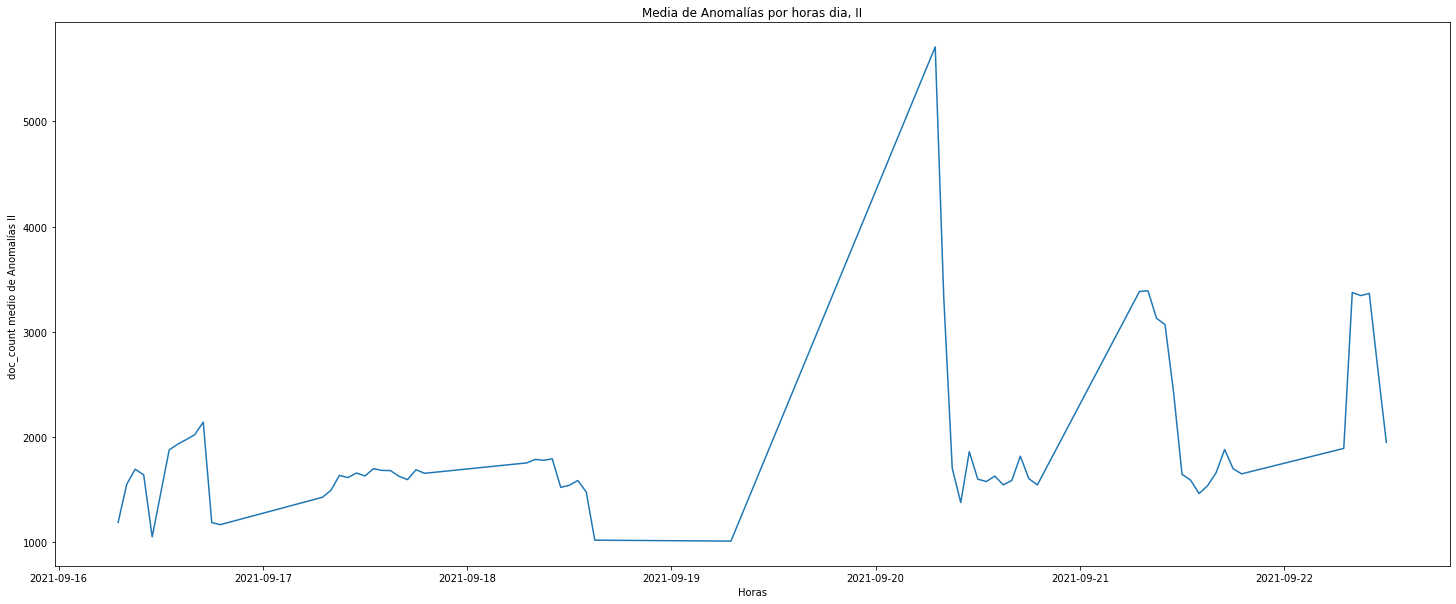

In [21]:
toplot = data_ii1[data_ii1['anomaly']==-1]['doc_count'].groupby('Fecha').mean()
plt.figure(figsize=(25,10))
plt.plot(toplot)
plt.title('Media de Anomalías por horas dia, II')
plt.xlabel('Horas')
plt.ylabel('doc_count medio de Anomalías II ')

<AxesSubplot:xlabel='count', ylabel='IP Origen'>

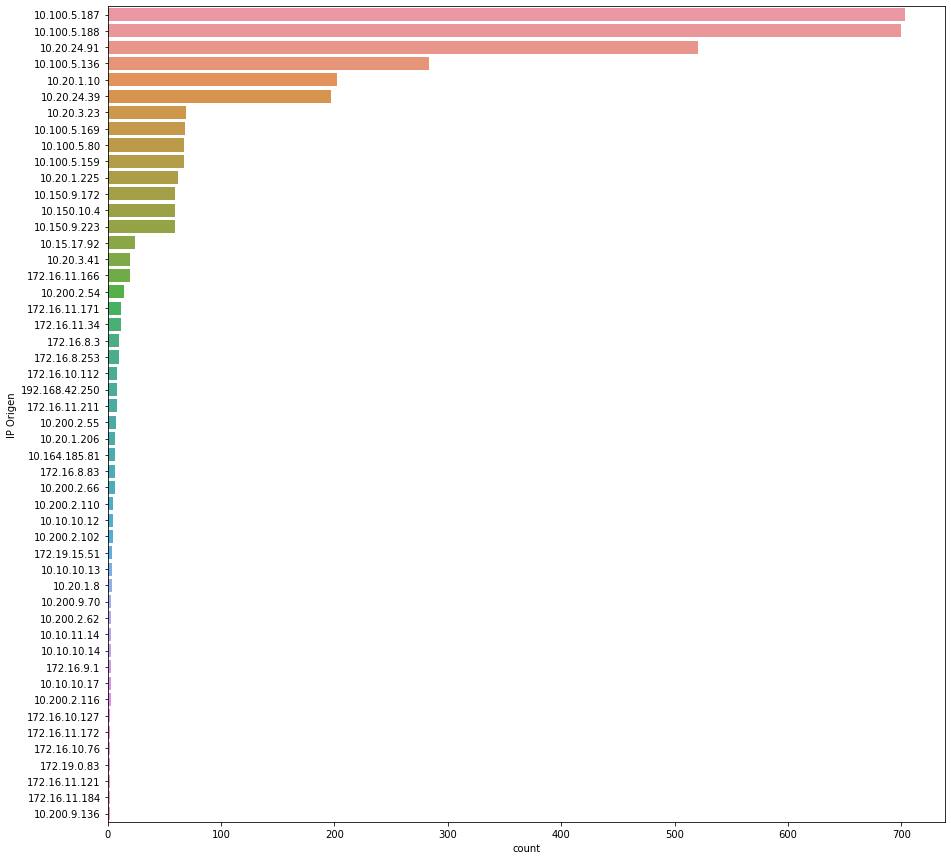

In [31]:
import seaborn as sns
toplot1 = data_ii1[data_ii1['anomaly']==-1]
toplot1 = toplot1.loc[toplot1['doc_count']>=1800]
plt.figure(figsize=(15,15))
sns.countplot(y='IP Origen', data = toplot1,
             order = toplot1['IP Origen'].value_counts().iloc[:50].index)

## Media de doc_count de las anomalías detectadas por hora ( II, noche)

Text(0, 0.5, 'doc_count medio de Anomalías II ')

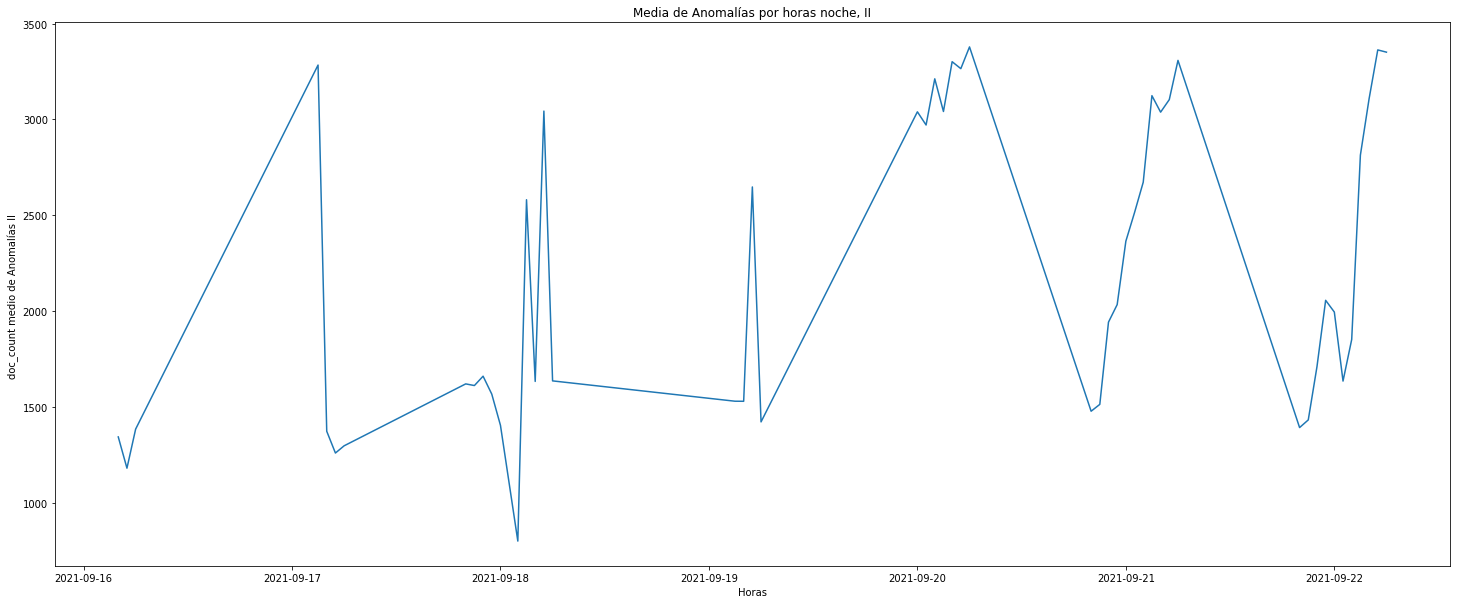

In [11]:
toplot = data_ii2[data_ii2['anomaly']==-1]['doc_count'].groupby('Fecha').mean()
plt.figure(figsize=(25,10))
plt.plot(toplot)
plt.title('Media de Anomalías por horas noche, II')
plt.xlabel('Horas')
plt.ylabel('doc_count medio de Anomalías II ')

<AxesSubplot:xlabel='count', ylabel='IP Origen'>

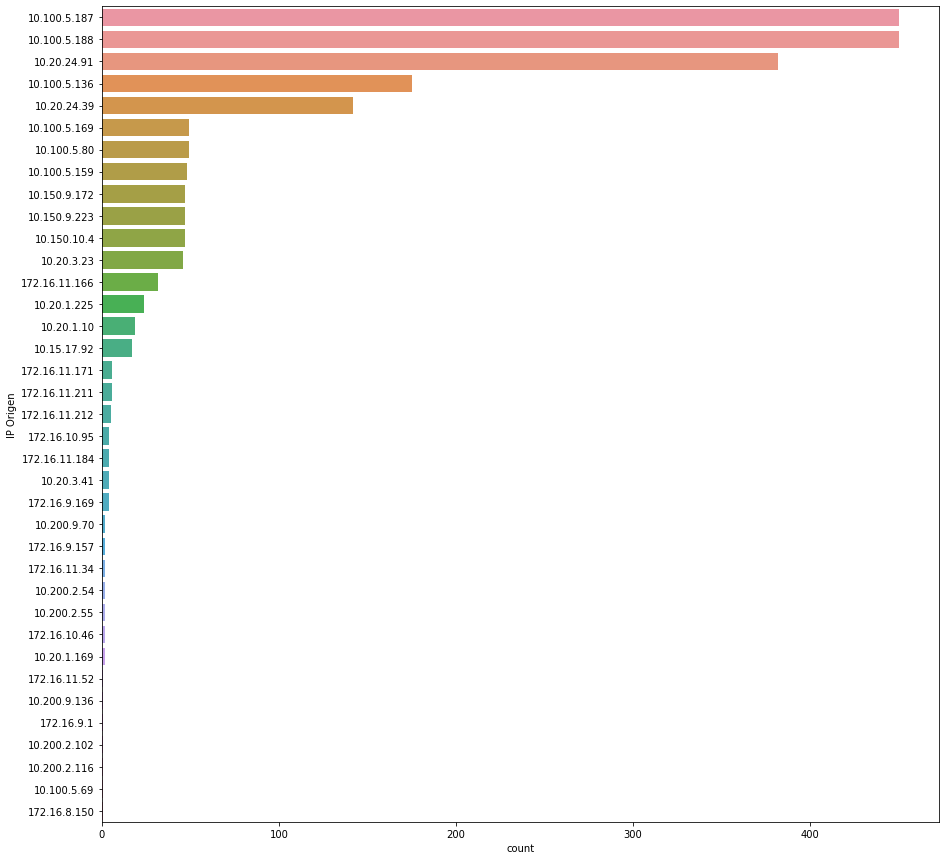

In [32]:
toplot2 = data_ii2[data_ii2['anomaly']==-1]
toplot2 = toplot2.loc[toplot2['doc_count']>=1800]
plt.figure(figsize=(15,15))
sns.countplot(y='IP Origen', data = toplot2,
             order = toplot2['IP Origen'].value_counts().iloc[:50].index)

## Media de doc_count de las anomalías detectadas por hora ( IE, día)

Text(0, 0.5, 'doc_count medio de Anomalías IE')

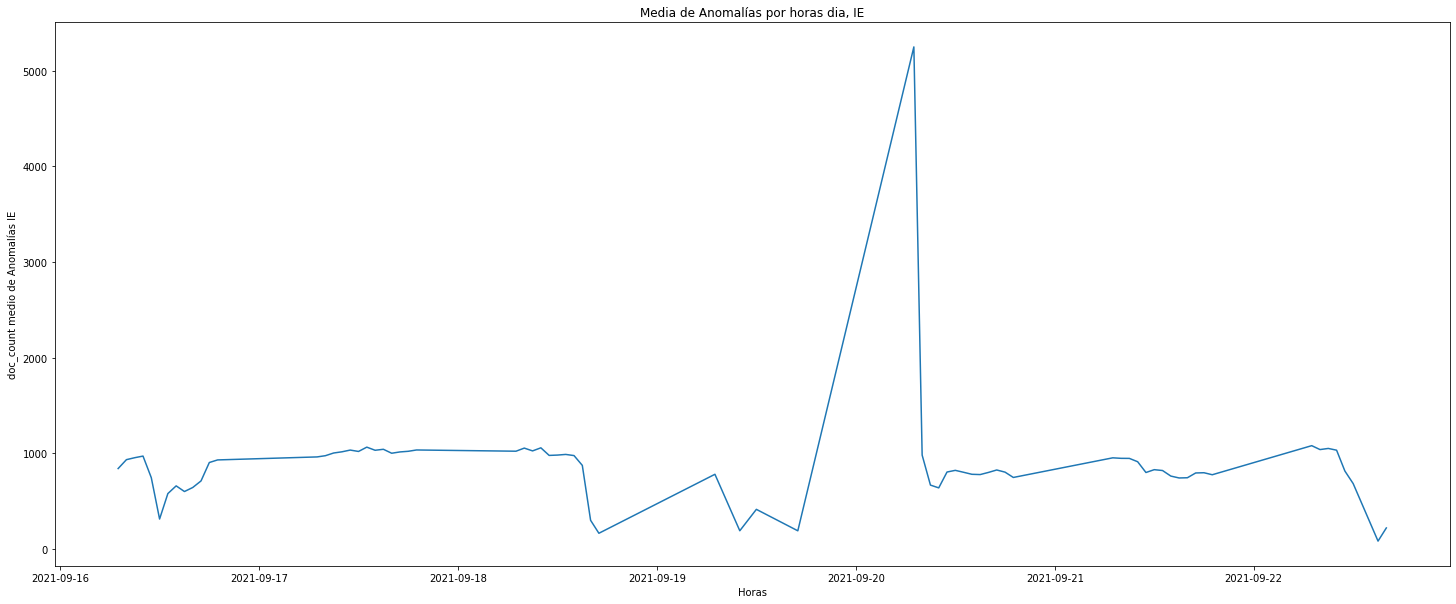

In [12]:
toplot = data_ie1[data_ie1['anomaly']==-1]['doc_count'].groupby('Fecha').mean()
plt.figure(figsize=(25,10))
plt.plot(toplot)
plt.title('Media de Anomalías por horas dia, IE')
plt.xlabel('Horas')
plt.ylabel('doc_count medio de Anomalías IE')

<AxesSubplot:xlabel='count', ylabel='IP Origen'>

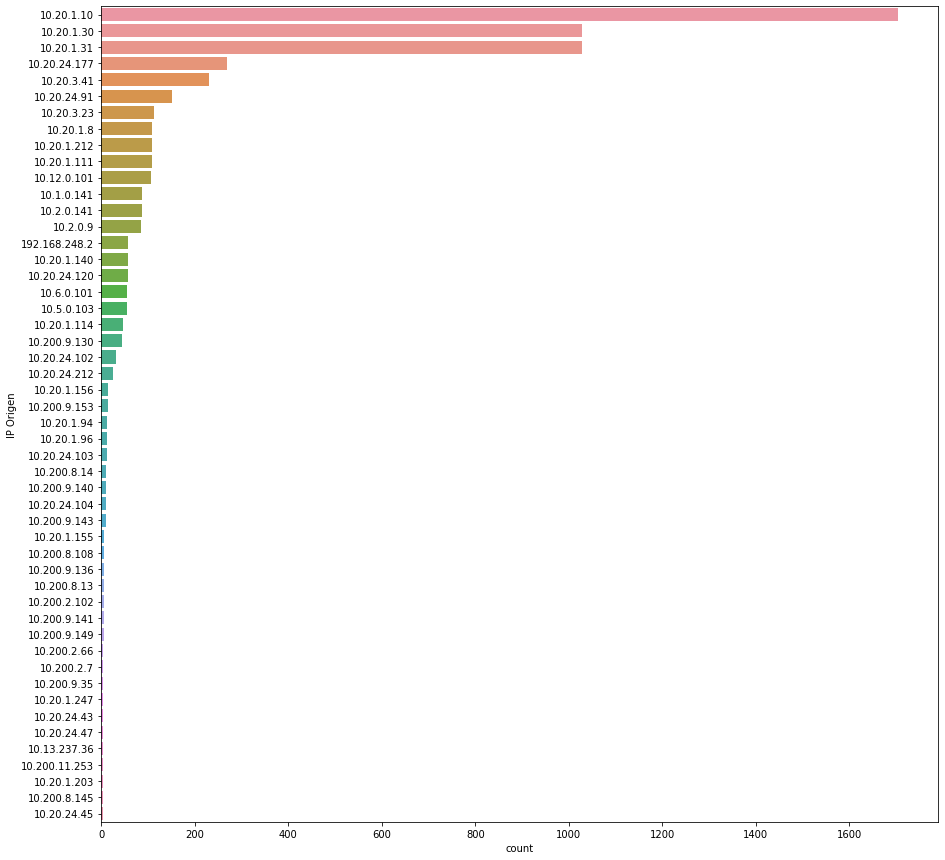

In [34]:
toplot3 = data_ie1[data_ie1['anomaly']==-1]
toplot3 = toplot3.loc[toplot3['doc_count']>=1000]
plt.figure(figsize=(15,15))
sns.countplot(y='IP Origen', data = toplot3,
             order = toplot3['IP Origen'].value_counts().iloc[:50].index)

## Media de doc_count de las anomalías detectadas por hora (IE, Noche)

Text(0, 0.5, 'doc_count medio de Anomalías IE')

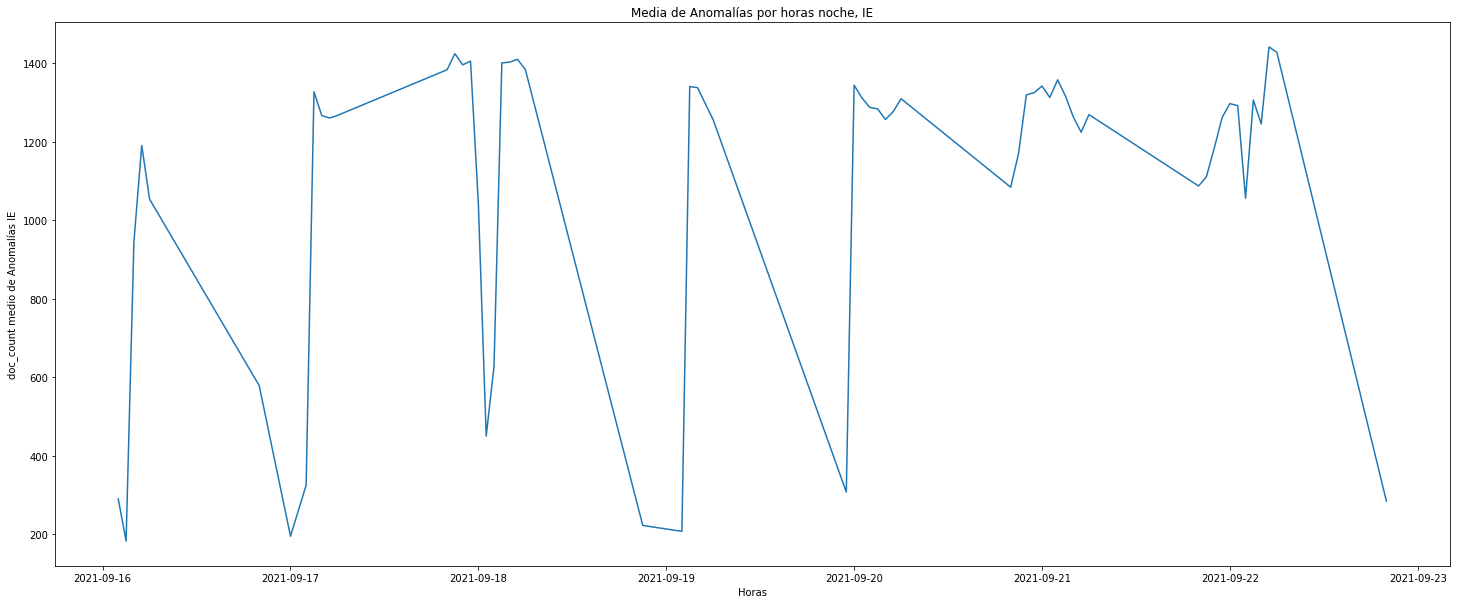

In [13]:
toplot = data_ie2[data_ie2['anomaly']==-1]['doc_count'].groupby('Fecha').mean()
plt.figure(figsize=(25,10))
plt.plot(toplot)
plt.title('Media de Anomalías por horas noche, IE')
plt.xlabel('Horas')
plt.ylabel('doc_count medio de Anomalías IE')

<AxesSubplot:xlabel='count', ylabel='IP Origen'>

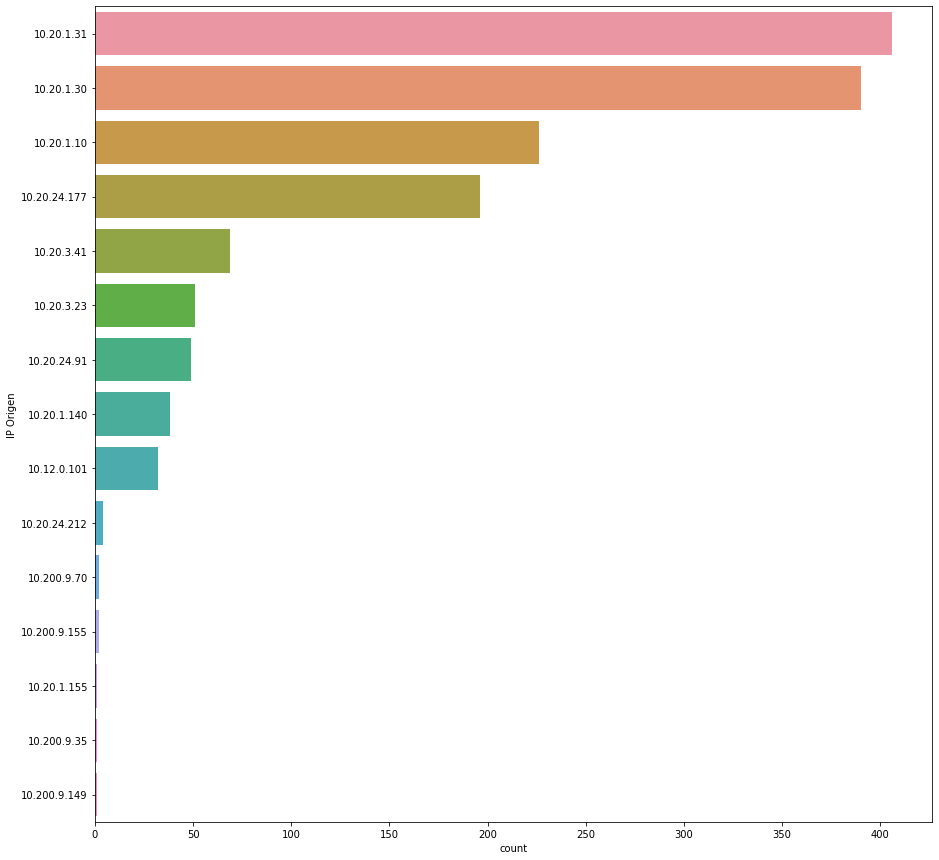

In [36]:
toplot4 = data_ie2[data_ie2['anomaly']==-1]
toplot4 = toplot4.loc[toplot4['doc_count']>=2000]
plt.figure(figsize=(15,15))
sns.countplot(y='IP Origen', data = toplot4,
             order = toplot4['IP Origen'].value_counts().iloc[:50].index)

## Media de doc_count de las anomalías detectadas por hora (EI, día)

Text(0, 0.5, 'doc_count medio de Anomalías EI')

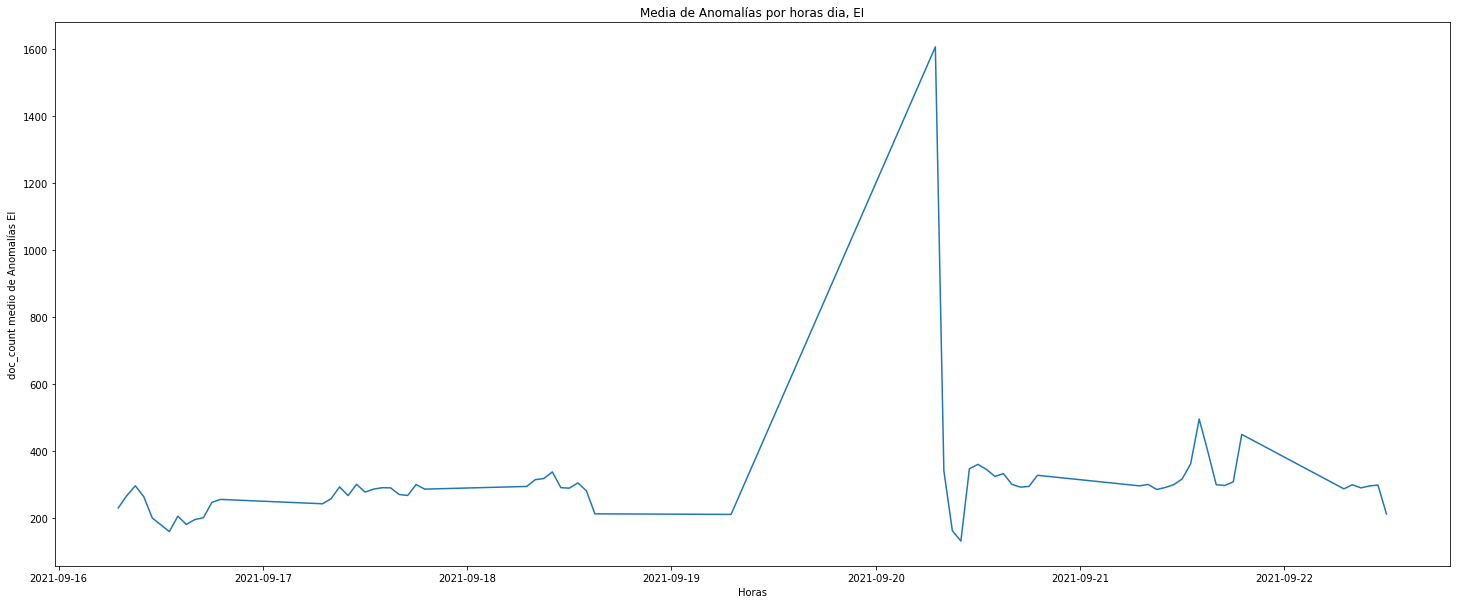

In [14]:
toplot = data_ei1[data_ei1['anomaly']==-1]['doc_count'].groupby('Fecha').mean()
plt.figure(figsize=(25,10))
plt.plot(toplot)
plt.title('Media de Anomalías por horas dia, EI')
plt.xlabel('Horas')
plt.ylabel('doc_count medio de Anomalías EI')


<AxesSubplot:xlabel='count', ylabel='IP Origen'>

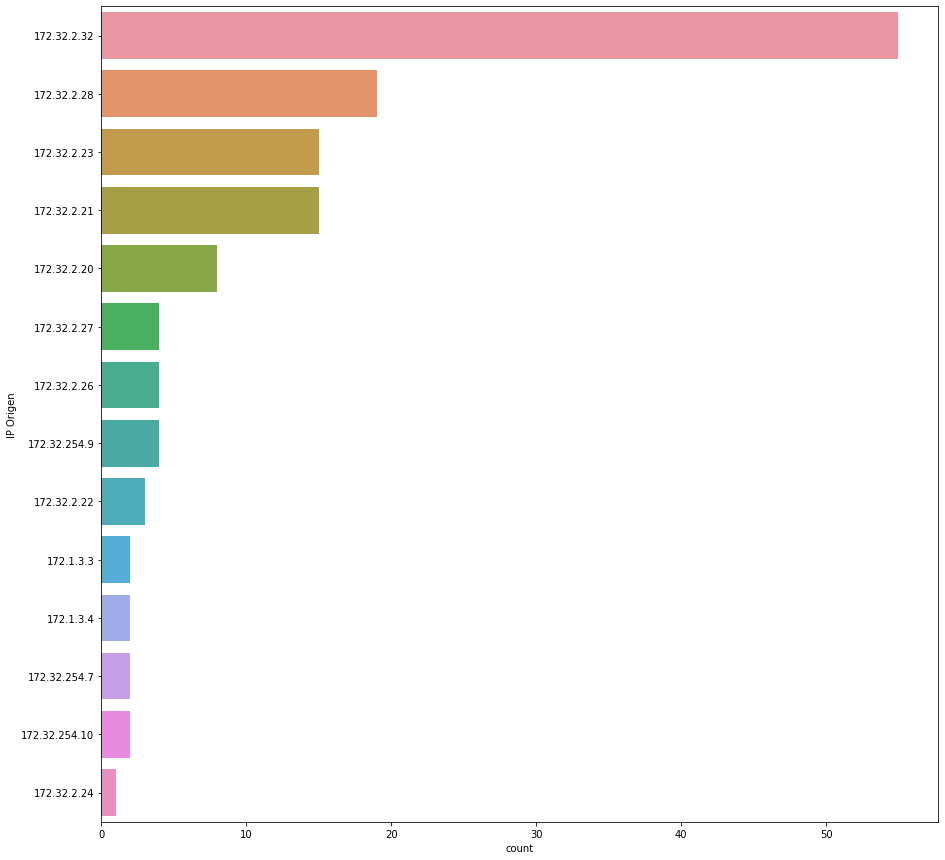

In [38]:
toplot5 = data_ei1[data_ei1['anomaly']==-1]
toplot5 = toplot5.loc[toplot5['doc_count']>=500]
plt.figure(figsize=(15,15))
sns.countplot(y='IP Origen', data = toplot5,
             order = toplot5['IP Origen'].value_counts().iloc[:50].index)

## Media de doc_count de las anomalías detectadas por hora ( EI, Noche)

Text(0, 0.5, 'doc_count medio de Anomalías EI')

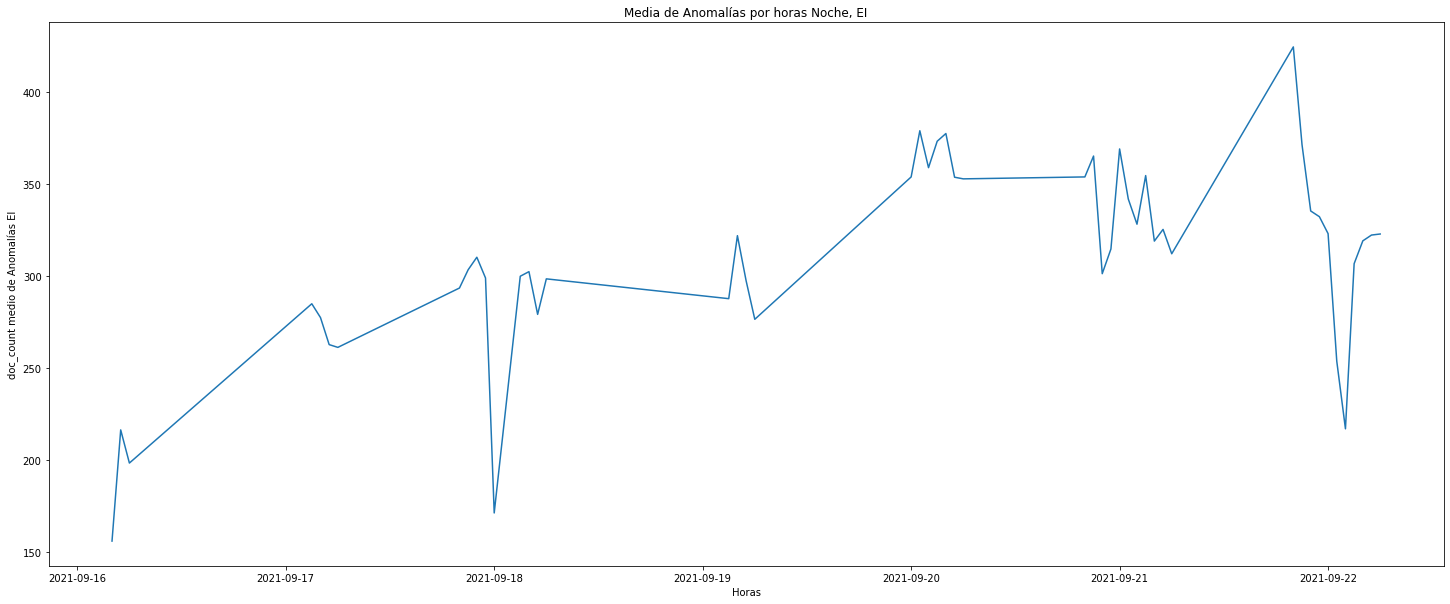

In [15]:
toplot = data_ei2[data_ei2['anomaly']==-1]['doc_count'].groupby('Fecha').mean()
plt.figure(figsize=(25,10))
plt.plot(toplot)
plt.title('Media de Anomalías por horas Noche, EI')
plt.xlabel('Horas')
plt.ylabel('doc_count medio de Anomalías EI')

<AxesSubplot:xlabel='count', ylabel='IP Origen'>

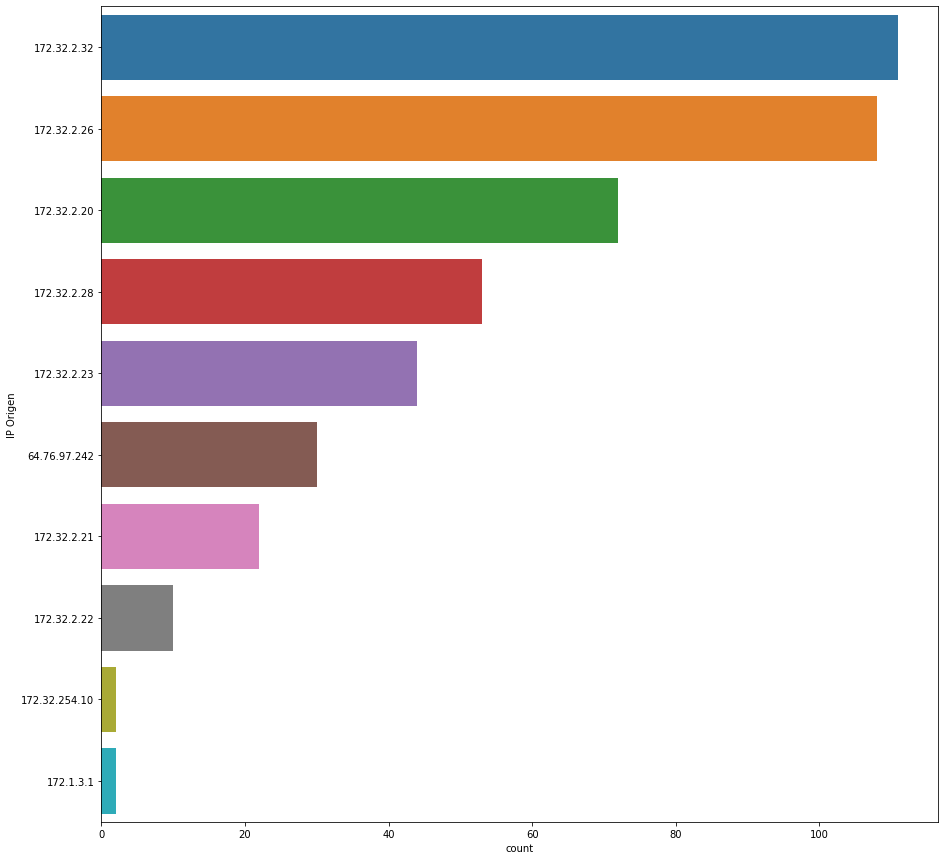

In [39]:
toplot6 = data_ei2[data_ei2['anomaly']==-1]
toplot6 = toplot6.loc[toplot6['doc_count']>=300]
plt.figure(figsize=(15,15))
sns.countplot(y='IP Origen', data = toplot6,
             order = toplot6['IP Origen'].value_counts().iloc[:50].index)

# ^ HASTA AQUI PARA LA REU PAO

In [16]:
df_list = [data_ii1,data_ii2,data_ie1,data_ie2, data_ei1,data_ei2]
df_labeled = pd.concat(df_list)
df_labeled.set_index('aux_indx')
df_labeled = df_labeled.sort_index(ascending = True)
df_labeled.reset_index()

,Fecha,IP Origen,IP Destino,Servicio,Accion,doc_count,ip_type_destino,Port Lvl,Action,aux_indx,ip_type_origen,ip_type_interaccion,anomaly
0,2021-09-16 02:00:00,192.168.248.2,3.216.56.135,18234,encrypt,2,Ext,Seguro,Paso,40,Int,IE,1
1,2021-09-16 02:00:00,172.16.10.101,10.20.1.28,80,accept,1,Int,Seguro,Paso,388,Int,II,1
2,2021-09-16 02:00:00,172.16.10.73,10.20.1.28,80,accept,1,Int,Seguro,Paso,387,Int,II,1
3,2021-09-16 02:00:00,172.16.10.65,10.20.1.28,80,decrypt,1,Int,Seguro,Paso,386,Int,II,1
4,2021-09-16 02:00:00,172.16.10.65,10.20.1.28,80,accept,1,Int,Seguro,Paso,385,Int,II,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471138,2021-09-22 20:00:00,10.100.5.187,10.15.17.10,28181,accept,4,Int,Seguro,Paso,7082914,Int,II,1
2471139,2021-09-22 20:00:00,10.100.5.187,10.15.17.10,28081,accept,4,Int,Seguro,Paso,7082913,Int,II,1
2471140,2021-09-22 20:00:00,10.100.5.187,10.15.17.10,28080,accept,4,Int,Seguro,Paso,7082912,Int,II,1
2471141,2021-09-22 20:00:00,10.100.5.187,10.15.17.12,443,accept,4,Int,Seguro,Paso,7082924,Int,II,1


In [17]:
df_labeled['IP Destino'].value_counts()

10.20.1.30        128946
10.20.1.31        116369
10.20.24.212       52874
10.20.1.28         40805
10.20.25.19        30849
                   ...  
157.245.64.95          1
23.56.217.214          1
200.245.255.33         1
23.59.115.118          1
104.77.26.29           1
Name: IP Destino, Length: 44825, dtype: int64

In [18]:
lista = df_labeled['IP Destino'].value_counts().to_list()
l2 = [x for x in lista if x>=138]

In [19]:
plt.figure(figsize=(15,15))
sns.countplot(y='IP Origen', data = data_describe,
             order = data_describe['IP Origen'].value_counts().iloc[:50].index)

NameError: name 'sns' is not defined

<Figure size 1080x1080 with 0 Axes>

In [ ]:
anomalia -> un modelo 

In [ ]:
(1) columna de anomalia: Filtro de interaccion, filtro dia/noche. 
    Hay cosas que no predice bien, por lo tanto:
(2) columna de anomalia2: IP, cantidad de conexiones > 138: Modelo Particular
                          IP, Cantidad de conexiones < 138 Modelo general con todos los datos cuyas conexiones sean < 138
(2) columna de anomalia3

In [ ]:
ip_filter = df_labeled[df_labeled['IP Origen']=='10.20.1.10']
ip_filter[ip_filter['anomaly']==1].describe()

# Autoencoder 

In [ ]:
ii_night = data_ii2

In [ ]:
ii_night = ii_night.reset_index()

In [ ]:
ii_night['IP Origen'].value_counts()

In [ ]:
ii_night_filter = ii_night[ii_night['IP Origen']=='10.20.1.28']

In [ ]:
ii_night_filter = ii_night_filter[['Fecha','doc_count','anomaly']]

In [ ]:
ii_night_filter['anomaly'].value_counts()

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=ii_night_filter[ii_night_filter['anomaly']==1]['Fecha'], y=ii_night_filter[ii_night_filter['anomaly']==1]['doc_count'], 
                         mode='markers', name='Non-anomaly',
                         marker=dict(color='blue')))
fig.add_trace(go.Scatter(x=ii_night_filter[ii_night_filter['anomaly']==-1]['Fecha'],
                         y=ii_night_filter[ii_night_filter['anomaly']==-1]['doc_count'], 
                         mode='markers', name='Anomaly',
                         marker=dict(color='green', size=13)))

In [ ]:
statistics.mean(ii_night_filter['doc_count'])

In [ ]:
ip_list = ii_night['IP Origen'].value_counts().index.to_list()
value_list = ii_night['IP Origen'].value_counts().to_list()
j2 = [x for x in value_list if x >= 138]

In [ ]:
ip_list = ip_list[:434]

In [ ]:
ii_night

In [ ]:
ip_list

In [ ]:
ii_night_filter = ii_night[ii_night['IP Origen']=='10.20.1.28']
def anomaly_labeler2(df):
    data = df[['doc_count','aux_indx']]
    outliers_fraction=0.01
    scaler = StandardScaler()
    np_scaled = scaler.fit_transform(data['doc_count'].values.reshape(-1, 1))
    data = pd.DataFrame(np_scaled)
    model =  IsolationForest(contamination=outliers_fraction)
    model.fit(data)
    df['anomaly2'] = model.predict(data)
    return df
ii_night_filter = anomaly_labeler2(ii_night_filter)    
    

In [ ]:
ii_night_filter['anomaly2'].value_counts()

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=ii_night_filter[ii_night_filter['anomaly2']==1]['Fecha'], y=ii_night_filter[ii_night_filter['anomaly2']==1]['doc_count'], 
                         mode='markers', name='Non-anomaly',
                         marker=dict(color='blue')))
fig.add_trace(go.Scatter(x=ii_night_filter[ii_night_filter['anomaly2']==-1]['Fecha'],
                         y=ii_night_filter[ii_night_filter['anomaly2']==-1]['doc_count'], 
                         mode='markers', name='Anomaly 2',
                         marker=dict(color='green', size=13)))

In [ ]:
# Grafico de ip de origen y barra de las anomalías con mayor a 2000 doc_count
